<a href="https://colab.research.google.com/github/BenYavor/Autoencoder_communication_system_WGAN_Channel-estimation/blob/master/Communication_Autoencoder_with_WGAN_and_pre_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
#from Clustering_Equalgrps.equal_groups import EqualGroupsKMeans
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
print(M)

SNR = 7


16


## Training Parameter

In [0]:
gen_learning_rate=0.0001
disc_learning_rate = 0.0001 

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

EncIn = tf.keras.layers.Input(shape=(M,))
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')



norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [5]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

def rayleigh_channel(x,noise_std):
    return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = gan_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()


def test_encoding_pre(M=16, n=1):
    inp = np.arange(0,M)
    coding = pre_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()    


# Models

#### Generator Model

In [0]:
def get_generator(n):
  input1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n)(input1)
  input2 =tf.random.normal(shape=tf.shape(input1))
  x2 = tf.keras.layers.Dense(n)(input2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(64,use_bias=True,  activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(64,use_bias=True, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[input1], outputs=out)
  return generator

#### Discriminator Model 

In [0]:
def get_discriminator(n):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=True, activation='sigmoid'))
  return model

number_of_disc_layers = 5

In [0]:
generator = get_generator(n)
discriminator = get_discriminator(n)

## Encoder and Pre-Encoder Model

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(n, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

def get_pre_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M,kernel_initializer=randN_initial, activation="elu"),
            keras.layers.Dense(n,kernel_initializer=randN_initial, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

## Decoder and Pre-Decoder Model

In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])
   return model


def get_pre_decoder(M):
   model= keras.models.Sequential([
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M,kernel_initializer=randN_initial, activation="elu"),
                keras.layers.Dense(M,kernel_initializer=randN_initial, activation="softmax")
                ])
   return model


In [0]:
@tf.function
def compute_loss(batch_size):
  m =random_sample(batch_size)
  r = pre_encoder(m)
  real_training_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
  fake_training_data = tf.concat(values=[generator(r),r], axis=1)
  real_output = discriminator(real_training_data)
  fake_output = discriminator(fake_training_data)
  disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)
  gen_loss = -tf.reduce_mean(fake_output)

  return disc_loss, gen_loss

### GAN Training functions

In [0]:
def gan_optimizers(gen_learning_rate  ,disc_learning_rate):
  generator_optimizer = tf.keras.optimizers.RMSprop(gen_learning_rate)      #RMSprop   in oreder to test where the error comes from
  discriminator_optimizer = tf.keras.optimizers.RMSprop(disc_learning_rate) 
  return generator_optimizer, discriminator_optimizer

In [14]:
%%time
loss =[]
def train_gan(epochs,n_steps, batch_size, SNR_level):
  noise_std = EbNo2Sigma(SNR_level)
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    counter += 1
    train_step(noise_std, n_steps,batch_size)
    if counter%100==0:
      tf.print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      loss.append(compute_loss(batch_size))
      losses.loc[len(losses)] = np.mean(loss, axis=0)
    if epoch%2000 == 0:
      real_eval_data, fake_eval_data, inputs = get_evaluation_data()
      test_eval(real_eval_data, fake_eval_data, inputs)
      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [0]:
@tf.function
def train_step(noise_std,n_steps,batch_size):
  m =random_sample(batch_size)
  r = pre_encoder(m)
  for i in range(n_steps):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
      fake_training_data = tf.concat(values=[generator(r),r], axis=1)
      real_output = discriminator(real_training_data)
      fake_output = discriminator(fake_training_data)
      
      
      disc_loss = -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)

      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        t=0
        for t in range(number_of_disc_layers):
          y = tf.clip_by_value(discriminator.trainable_weights[t],clip_value_min=-0.05,clip_value_max=0.05,name=None)
          discriminator.trainable_weights[t].assign(y)


    
      if i == 4:
        fake_training_data = tf.concat(values=[generator(r),r], axis=1)
        fake_output = discriminator(fake_training_data)
        gen_loss = -tf.reduce_mean(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



In [0]:
def creating_and_train_gan(epochs,n_steps, batch_size, SNR_level , n ):  #optional Leraning Rates
  train_gan(epochs, n_steps, batch_size, SNR_level)
  #after GAN training
  generator.trainable = False
  tf.print(generator.trainable)

In [0]:
def gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

def Test_AE_rayleigh(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = rayleigh_channel(code_word, noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  fake_eval_data = generator([x])
  real_eval_data = real_channel(x,noise_std) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs=100):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 1
  
  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()

# Pre Autoencoder Training

Train on 10000000 samples
Epoch 1/5
  197500/10000000 [..............................] - ETA: 1:04 - loss: 0.0024 - accuracy: 1.0000Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, None)              562       
_________________________________________________________________
sequential_1 (Sequential)    (None, 16)                320       
Total params: 882
Trainable params: 882
Non-trainable params: 0
_________________________________________________________________


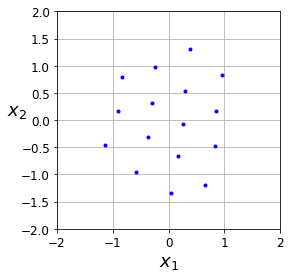

(10000000,)
(10000000, 2)


In [19]:
pre_decoder = get_pre_decoder(M)
pre_encoder = get_pre_encoder(M)



gan_AE = tf.keras.models.Sequential([pre_encoder,pre_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=400, epochs=5)
gan_AE.summary() 
test_encoding_pre(M,n) 

print(data.shape)
print(pre_encoder(data).shape)

# GAN Training

In [0]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

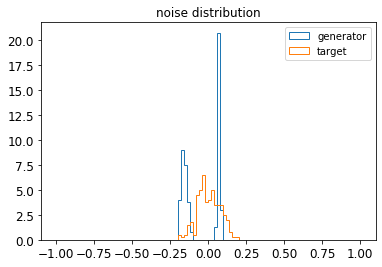

Time for epoch 100 is 12.789371967315674 sec,
Time for epoch 200 is 13.39271354675293 sec,
Time for epoch 300 is 13.715794324874878 sec,
Time for epoch 400 is 14.038617849349976 sec,
Time for epoch 500 is 14.359538555145264 sec,
Time for epoch 600 is 14.70121955871582 sec,
Time for epoch 700 is 15.051440954208374 sec,
Time for epoch 800 is 15.379928350448608 sec,
Time for epoch 900 is 15.702333688735962 sec,
Time for epoch 1000 is 16.03149700164795 sec,
Time for epoch 1100 is 16.38927912712097 sec,
Time for epoch 1200 is 16.707794904708862 sec,
Time for epoch 1300 is 17.048623085021973 sec,
Time for epoch 1400 is 17.4264657497406 sec,
Time for epoch 1500 is 17.792316675186157 sec,
Time for epoch 1600 is 18.154989004135132 sec,
Time for epoch 1700 is 18.518080472946167 sec,
Time for epoch 1800 is 18.90852165222168 sec,
Time for epoch 1900 is 19.2363064289093 sec,
Time for epoch 2000 is 19.586666345596313 sec,


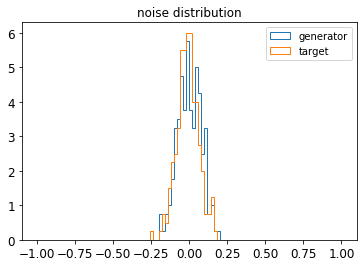

Time for epoch 2100 is 27.736371517181396 sec,
Time for epoch 2200 is 28.099313020706177 sec,
Time for epoch 2300 is 28.456794500350952 sec,
Time for epoch 2400 is 28.81292200088501 sec,
Time for epoch 2500 is 29.136471033096313 sec,
Time for epoch 2600 is 29.463388442993164 sec,
Time for epoch 2700 is 29.778196096420288 sec,
Time for epoch 2800 is 30.111878395080566 sec,
Time for epoch 2900 is 30.44995379447937 sec,
Time for epoch 3000 is 30.788818836212158 sec,
Time for epoch 3100 is 31.103501558303833 sec,
Time for epoch 3200 is 31.42489743232727 sec,
Time for epoch 3300 is 31.771403074264526 sec,
Time for epoch 3400 is 32.10830593109131 sec,
Time for epoch 3500 is 32.46681475639343 sec,
Time for epoch 3600 is 32.79906606674194 sec,
Time for epoch 3700 is 33.15981984138489 sec,
Time for epoch 3800 is 33.567506074905396 sec,
Time for epoch 3900 is 33.933006048202515 sec,
Time for epoch 4000 is 34.36258268356323 sec,


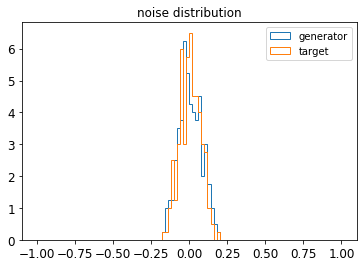

Time for epoch 4100 is 42.80874586105347 sec,
Time for epoch 4200 is 43.17650866508484 sec,
Time for epoch 4300 is 43.52290320396423 sec,
Time for epoch 4400 is 43.88658857345581 sec,
Time for epoch 4500 is 44.30050468444824 sec,
Time for epoch 4600 is 44.62642431259155 sec,
Time for epoch 4700 is 44.99700117111206 sec,
Time for epoch 4800 is 45.40667796134949 sec,
Time for epoch 4900 is 45.791879653930664 sec,
Time for epoch 5000 is 46.14869523048401 sec,
Time for epoch 5100 is 46.489418268203735 sec,
Time for epoch 5200 is 46.80338501930237 sec,
Time for epoch 5300 is 47.13168954849243 sec,
Time for epoch 5400 is 47.49565148353577 sec,
Time for epoch 5500 is 47.85700798034668 sec,
Time for epoch 5600 is 48.216978788375854 sec,
Time for epoch 5700 is 48.5670051574707 sec,
Time for epoch 5800 is 48.93273186683655 sec,
Time for epoch 5900 is 49.30377745628357 sec,
Time for epoch 6000 is 49.670082569122314 sec,


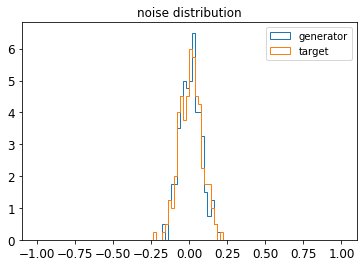

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 58.82082509994507 sec,
False
Time for the training is 58.82996439933777 sec,
CPU times: user 1min 14s, sys: 802 ms, total: 1min 15s
Wall time: 58.8 s


In [21]:
%%time

generator_optimizer, discriminator_optimizer = gan_optimizers(gen_learning_rate=gen_learning_rate, disc_learning_rate = disc_learning_rate)
start = time.time()
creating_and_train_gan(epochs= 6001,n_steps=5, batch_size =100, SNR_level = 7, n = n)
time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))


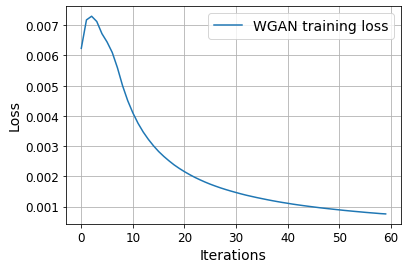

In [22]:
plt.plot(losses.disc_loss.values) 
plt.ylabel("Loss", fontsize=14, rotation=90)
plt.xlabel("Iterations", fontsize=14)
plt.legend(['WGAN training loss'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")


# AE training

In [23]:
%%time

gan_decoder = get_gan_decoder(M)
gan_encoder = get_gan_encoder(M)



gan_AE = tf.keras.models.Sequential([gan_encoder,generator,gan_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=200, epochs=20)
time_to_train_gan += time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))
gan_AE.summary()  

Train on 10000000 samples
Epoch 1/20
  100000/10000000 [..............................] - ETA: 2:06 - loss: 0.1240 - accuracy: 0.9575Time for the training is 27.75193214416504 sec,
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, None)              1922      
_________________________________________________________________
model (Model)                (None, 2)                 4622      
_________________________________________________________________
sequential_4 (Sequential)    (None, 16)                1680      
Total params: 8,224
Trainable params: 3,602
Non-trainable params: 4,622
_________________________________________________________________
CPU times: user 34.7 s, sys: 1.19 s, total: 35.9 s
Wall time: 28.1 s


### Training MI

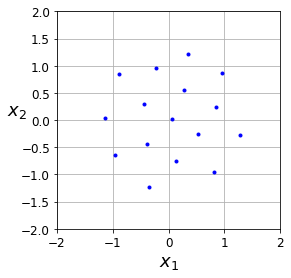

In [24]:
gan_encoder.trainable = False
gan_decoder.trainable = False

test_encoding(M,n)   


In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

### Comparison

In [26]:
gan_bber_data = gan_Test_AE(test_msg)
bber_data_rayleigh = Test_AE_rayleigh(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts
Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


time to train the AE Model with WGAN 86.58188915252686


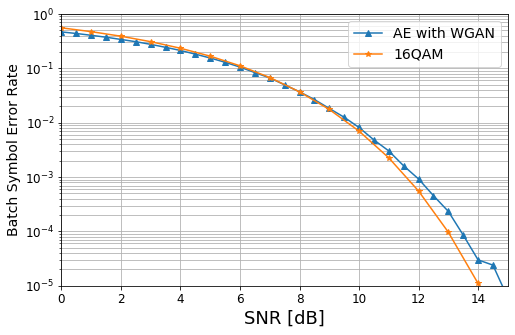

In [27]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with WGAN', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
print('time to train the AE Model with WGAN',time_to_train_gan)


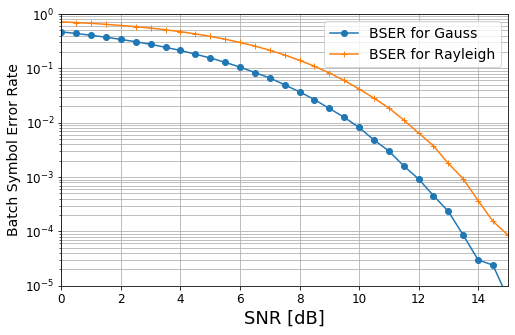

In [28]:
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], 'o-')
plt.semilogy(bber_data_rayleigh[0], bber_data_rayleigh[1], '+-')
#plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['BSER for Gauss','BSER for Rayleigh'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")